In [1]:
%%capture
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
import importlib
for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}
import kooplearn
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import NystroemKernel
from kooplearn.data import traj_to_contexts
from sklearn.preprocessing import StandardScaler
import scipy 
from scipy import stats
from tqdm import tqdm

In [2]:
def make_training_windows_week(date_prediction):
    """
    Parameters
    -----------------------------------------------------------------

    date_prediction : date with hour,
    the date on which we want to predict the electricity consumption
    ----------------------------------------------------------------

    returns

    windows : a dataframe which rows correspond to the dates on which a classifier will train

    """
    date_prediction = pd.to_datetime(date_prediction)
    last_training_date = date_prediction - pd.Timedelta(days=1)
    first_training_date = date_prediction - pd.Timedelta(days=8)
    concerned_hours = [3,8,13,18,23]

    whole_training_dates = pd.date_range(start=first_training_date,end=last_training_date,freq='h')
    training_dates = whole_training_dates[whole_training_dates.hour.isin(concerned_hours)].copy()
    dict_windows = {}
    
    for i in range(len(concerned_hours)): #because we only want to predict the following day
        begin_train_seq = first_training_date+pd.Timedelta(days=i)
        end_train_seq = begin_train_seq + pd.Timedelta(days=31)
        set_i = pd.date_range(start=begin_train_seq,end=end_train_seq,freq='h')
        set_i = set_i[set_i.hour.isin(concerned_hours)]
        dict_windows[f'set_{i}'] = set_i

    windows = pd.DataFrame.from_dict(data=dict_windows)

    return windows

We first recover the data, sadly, there is no URL to use the different dataset, so I had to download them locally.

In [3]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/Dynamical_system/data')
data_2019 = pd.read_csv('data_2019.csv',sep=';')
data_2020 = pd.read_csv('data_2020.csv',sep=';')
data_2021 = pd.read_csv('data_2021.csv',sep=';')
data_2022 = pd.read_csv('data_2022.csv',sep=';')
prices = pd.read_csv('France.csv')
os.chdir(actual_path)
%run functions.ipynb
%run mixture

/tmp/ipykernel_990/435856672.py:5: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('data_2021.csv',sep=';')


In [4]:
whole_data = pd.concat([data_2019,data_2020,data_2021,data_2022])

In [5]:
whole_data = whole_data.reset_index(drop=True)

In [6]:
list_to_drop = ['Périmètre','Prévision J-1','Prévision J',
                ' Stockage batterie',
                'Déstockage batterie','Eolien terrestre',
                'Eolien offshore',
                'Unnamed: 40','Nature']
#the variables related to the batteries and both the ones 
#containing informations about offshore and onshore
#wind are deleted because they only contain NaN values

In [7]:
use_data = whole_data.drop(list_to_drop,axis=1).copy()

In [8]:
use_data = use_data.dropna()

In [9]:
use_data.loc[:, 'Heures'] = use_data['Heures'].apply(lambda x: f"{x}:00" if len(x.split(':')) == 2 else x)
use_data['Heures'] = pd.to_timedelta(use_data['Heures']) #a quick manipulation to add the hours to the date

In [10]:
use_data['date'] = pd.to_datetime(use_data['Date']) + use_data['Heures']

In [11]:
use_data.drop(['Heures'],axis=1,inplace=True)

In [12]:
prices_period = prices[prices['Datetime (Local)'] >= '2019-01-01 00:00:00'].copy()

In [13]:
prices_period #an overview of the dataset

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
35063,France,FRA,2018-12-31 23:00:00,2019-01-01 00:00:00,51.00
35064,France,FRA,2019-01-01 00:00:00,2019-01-01 01:00:00,46.27
35065,France,FRA,2019-01-01 01:00:00,2019-01-01 02:00:00,39.78
35066,France,FRA,2019-01-01 02:00:00,2019-01-01 03:00:00,27.87
35067,France,FRA,2019-01-01 03:00:00,2019-01-01 04:00:00,23.21
...,...,...,...,...,...
87617,France,FRA,2024-12-29 17:00:00,2024-12-29 18:00:00,134.40
87618,France,FRA,2024-12-29 18:00:00,2024-12-29 19:00:00,133.72
87619,France,FRA,2024-12-29 19:00:00,2024-12-29 20:00:00,123.92
87620,France,FRA,2024-12-29 20:00:00,2024-12-29 21:00:00,118.59


In [14]:
prices_period.drop(['Country','ISO3 Code','Datetime (UTC)'],axis=1,inplace=True)

In [15]:
prices_period['Datetime (Local)'] = pd.to_datetime(prices_period['Datetime (Local)'])
whole_period = prices_period.merge(use_data,how='left',left_on='Datetime (Local)',
                                  right_on='date')

In [16]:
whole_period.drop('Datetime (Local)',axis=1,inplace=True)

In [17]:
whole_period.columns

Index(['Price (EUR/MWhe)', 'Date', 'Consommation', 'Fioul', 'Charbon', 'Gaz',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', 'date'],
      dtype='object')

In [18]:
whole_period.columns = ['price','date_wo_h','conso','fioul','coal','gas',
                       'nuclear','wind','sun','hydro','pump','bioenergy','physics',
                        'exchange_uk','exchange_sp','exchange_it','exchange_sw',
                        'exchange_gr','co2_rate','fioul_tac','fioul_cogen',
                        'fioul_other','gas_tac',
                       'gas_cogen','gas_ccg','gas_other','hydro_river','hydro_lake',
                       'hydro_turbine','bio_waste','bio_biomass','bio_biogas','date']
#we rename the columns for clarity and simplicity

In [19]:
whole_period.dropna(inplace=True)

Text(0.5, 1.0, 'the evolution of the price (euro/MWhe) of electricity')

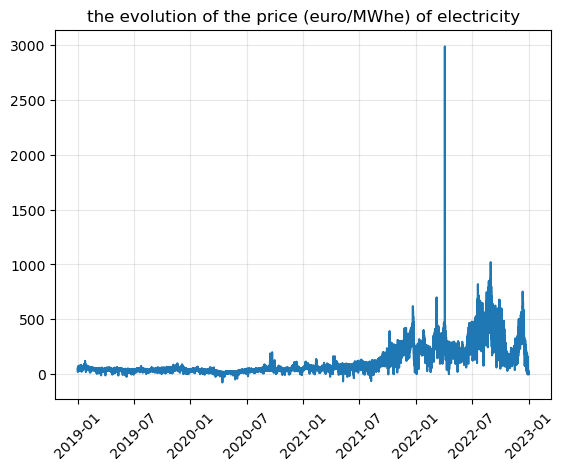

In [20]:
fig, ax = plt.subplots()
ax.plot(whole_period['date'],whole_period['price'])
ax.tick_params(axis='x', labelrotation=45)
ax.grid(alpha=0.3)
plt.title('the evolution of the price (euro/MWhe) of electricity')

In [21]:
whole_period['cos_day'] = whole_period['date'].dt.day.astype(float)
whole_period['sin_day'] = whole_period['date'].dt.day.astype(float)
whole_period['cos_month'] = whole_period['date'].dt.month.astype(float)
whole_period['sin_month'] = whole_period['date'].dt.month.astype(float)

In [22]:
whole_period['cos_day'] = cos_transformer(365).fit_transform(whole_period['cos_day'])
whole_period['cos_month'] = cos_transformer(12).fit_transform(whole_period['cos_month'])
whole_period['sin_day'] = sin_transformer(365).fit_transform(whole_period['sin_day'])
whole_period['sin_month'] = sin_transformer(12).fit_transform(whole_period['sin_month'])

In [23]:
%%capture
fig, ax = plt.subplots()
for i in ['cos_day','sin_day','cos_month','sin_month']:
    ax.plot(whole_period[f'{i}'],label=f'{i}')
    ax.legend()

In [24]:
whole_period['weekdays'] = whole_period['date'].dt.dayofweek
whole_period['weekend'] = np.zeros(whole_period.shape[0])
whole_period['not_weekend'] = np.zeros(whole_period.shape[0])
whole_period['date_wo_h'] = pd.to_datetime(whole_period['date_wo_h'])

In [25]:
for i in range(whole_period.shape[0]):
    if whole_period.loc[i,'weekdays'] == 5 or whole_period.loc[i,'weekdays'] == 6:
        whole_period.loc[i,'weekend'] = 1
    else:
        whole_period.loc[i,'not_weekend'] = 1

In [26]:
#we need to add the 2 days lagged of fossil fuel and nuclear production
#we cannot add what they call the announced availability because they don't 
#describe how they find it and on the majority of ressources concerning 
#the matter, we only have access to the effective production

In [27]:
whole_period['2_lags_coal'] = whole_period['coal'].shift(48)
whole_period['2_lags_fioul'] = whole_period['fioul'].shift(48)
whole_period['2_lags_gas'] = whole_period['gas'].shift(48)
whole_period['2_lags_nuke'] = whole_period['nuclear'].shift(48)
whole_period['target_price'] = whole_period['price'].shift(24)

In [28]:
whole_period.dropna(inplace=True) #we just loose two days

In [29]:
training_data = whole_period[whole_period['date_wo_h'].dt.year < 2022].copy()
test_data = whole_period[whole_period['date_wo_h'].dt.year == 2022].copy()
list_imp_hours = [3,8,13,18,23] #as done in the article, we select those hours as it reduces the computational 
#cost and it represents well the evolution of the data over the day

In [30]:
training_data = training_data[training_data['date'].dt.hour.isin(list_imp_hours)]
test_data = test_data[test_data['date'].dt.hour.isin(list_imp_hours)]
for_plots_date = test_data['date']
for_plots_train = training_data['date']
training_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

## A simple implementation on a single day
We use the make_training_windows_week function that creates training windows corresponding to the procedure of the 'new' OSSCP horizon approach. An important part of the innovations provided in the article is the use of an online aggregation procedure made possible by the new 'splitting' of the data. 

Concerning the feasibility of this experiment, it became hardly reproductible in Python as the package they use (OPERA) is in R. After a bit of research, it appears that there was a version of this package in Python but after a few hours of test (as the documentation is quite short and some properties are not explained in great detail), I managed to run the main functions. However, it turns out that an error appears. And after having checked the code of the said function, the error came from the fact that if there was an 'if' missing depending on the options used to run it. As I am not very familiar with the topics evolving around online learning, I thought it would be better not to try and correct their code as I could spend too much time on it with poor results. 

On this first experiment, we will try to predict the hourly prices of the 29th of may of 2019. I chose this date because in theory, there shouldn't be too much volatility in the prices as less electricity is needed in summer.

In [31]:
training_dates = pd.date_range(start='2019-01-03',end='2019-01-14',freq='h')
training_dates = training_dates[training_dates.hour.isin(list_imp_hours)]

In [32]:
get_windows = make_training_windows_week('2019-05-29')

In [33]:
reg_05_dict = {}
reg_95_dict = {}
reg_50_dict = {}

In [34]:
count = 0
for i in get_windows.columns:
    list_train = get_windows[i]
    training_set_part = training_data[training_data['date'].isin(list_train)]
    reg_05_dict[f'reg_{count}'] = QuantileRegressor(quantile=0.05).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                  y=training_set_part['target_price'])
    reg_95_dict[f'reg_{count}'] = QuantileRegressor(quantile=0.95).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                  y=training_set_part['target_price'])
    reg_50_dict[f'reg_{count}'] = QuantileRegressor(quantile=0.5).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                  y=training_set_part['target_price'])
    count += 1

    

In [35]:
predictions_05 = np.zeros((0,5))
predictions_95 = np.zeros((0,5))
predictions_50 = np.zeros((0,5))
for i in range(count-1):
    to_pred = training_data[training_data['date_wo_h'] == pd.to_datetime('2019-05-29')].drop(['target_price','date','date_wo_h'],axis=1)
    predictions_05 = np.vstack((predictions_05,reg_05_dict[f'reg_{i}'].predict(to_pred)))
    predictions_95 = np.vstack((predictions_95,reg_95_dict[f'reg_{i}'].predict(to_pred)))
    predictions_50 = np.vstack((predictions_50,reg_50_dict[f'reg_{i}'].predict(to_pred)))

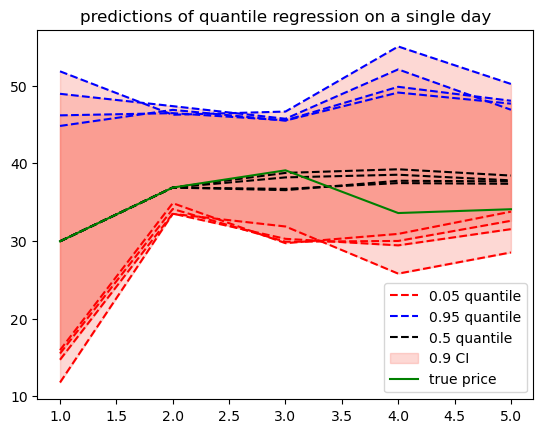

In [36]:
test = np.array(training_data[training_data['date_wo_h'] == pd.to_datetime('2019-05-29')]['target_price'])
fig, ax = plt.subplots()
index = np.linspace(start=1,stop=5,num=5)
for i in range(3):
    ax.plot(index,predictions_05[i,:],'r--')
    ax.plot(index,predictions_95[i,:],'b--')
    ax.plot(index,predictions_50[i,:],'k--')
    ax.fill_between(index,predictions_05[i,:],predictions_95[i,:],color='salmon',alpha=0.3)

ax.plot(index,predictions_05[3,:],'r--',label='0.05 quantile')
ax.plot(index,predictions_95[3,:],'b--',label='0.95 quantile')
ax.plot(index,predictions_50[3,:],'k--',label='0.5 quantile')
ax.fill_between(index,predictions_05[3,:],predictions_95[3,:],color='salmon',alpha=0.3,label='0.9 CI')
plt.plot(index,test,'g-',label='true price')
plt.title('predictions of quantile regression on a single day')
ax.legend()

In [37]:
#after a few tries demanding a lot of computational power
#I selected a few variables that seemed, as said in the article
#the most important ones
copy_koop = training_data[['price','target_price','nuclear','2_lags_nuke']].copy()
for col in copy_koop.columns:
    copy_koop[col] = stats.zscore(copy_koop[col]) 
copy_koop['target_last'] = copy_koop['target_price'].copy()
copy_koop.drop('target_price',axis=1,inplace=True)
copy_koop_np = copy_koop.to_numpy()

In [38]:
kernel = RBF(length_scale=0.8)
tr_ctx = traj_to_contexts(copy_koop_np[:30,:],time_lag=2,context_window_len=3)
ts_ctx = traj_to_contexts(copy_koop_np[30:40,:],time_lag=2,context_window_len=3)

In [39]:
nys_rrr = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=10,num_centers=500)
nys_rrr.fit(tr_ctx)
pred = nys_rrr.predict(ts_ctx)
true = ts_ctx.lookforward(nys_rrr.lookback_len)
rmse = np.sqrt((np.sum((pred-true)**2)))/ts_ctx.shape[0]

In [40]:
print(rmse)

0.1711885918295516


Text(0.5, 1.0, 'predictions using kooplearn (prices are standardised)')

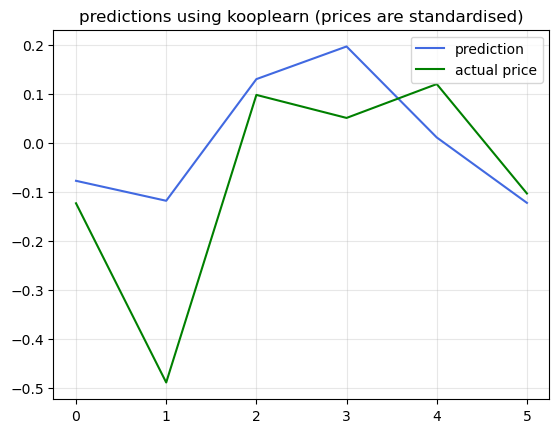

In [41]:
fig, ax = plt.subplots()

ax.grid(alpha=0.3)
ax.plot(pred[:,0,-1],'-',color='royalblue',label='prediction')
ax.plot(copy_koop_np[34:40,-1],'g-',label='actual price')
ax.legend()
plt.title('predictions using kooplearn (prices are standardised)')

In [42]:
pred_bis = nys_rrr.predict(tr_ctx)

Text(0.5, 1.0, 'predictions on the training data (prices are standardised)')

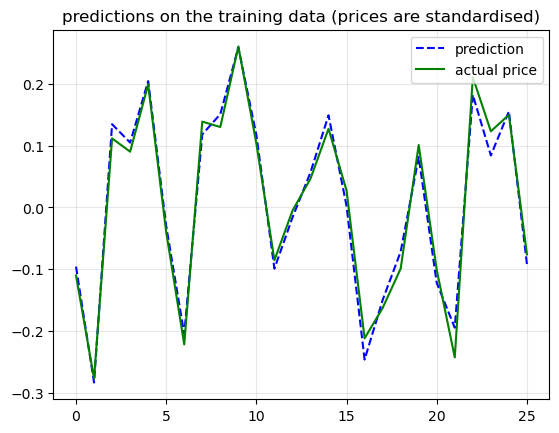

In [43]:
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(pred_bis[:,0,-1],'b--',label='prediction')
ax.plot(copy_koop_np[4:30,-1],'g-',label='actual price')
ax.legend()
plt.title('predictions on the training data (prices are standardised)')

## On a whole month 
As precised in the article, before 2020, the different methods managed to have very satisfying results. The prices were relatively smooth and hence good performance could be reached. In order to compare it with the difficult periods following 2020 and even 2023 (which seems to be an even more volatile year), we first try on a month that once again seems to be pretty 'simple'.

In [44]:
target_june = pd.date_range(start='2019-06-01',end='2019-06-30',freq='h')
target_june_dates = pd.date_range(start='2019-06-01',end='2019-06-30',freq='d')

In [45]:
reg_05_june = {}
reg_50_june = {}
reg_95_june = {}
pred_whole_05 = np.zeros((4,0))
pred_whole_95 = np.zeros((4,0))
pred_whole_50 = np.zeros((4,0))
predictions_koop = np.zeros((0,4))
for day in tqdm(target_june_dates):
    predictions_05_june = np.zeros((0,5))
    predictions_95_june = np.zeros((0,5))
    predictions_50_june = np.zeros((0,5))
    corresponding_training_windows = make_training_windows_week(day)
    count = 0
    for col in corresponding_training_windows.columns:
        list_train = corresponding_training_windows[col]
        training_set_part = training_data[training_data['date'].isin(list_train)]
        reg_05_june[f'reg_{count}'] = QuantileRegressor(quantile=0.05).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_95_june[f'reg_{count}'] = QuantileRegressor(quantile=0.95).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_50_june[f'reg_{count}'] = QuantileRegressor(quantile=0.5).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        count += 1
    for i in range(count-1):
        to_pred = training_data[training_data['date_wo_h'] == pd.to_datetime(day)].drop(['target_price','date','date_wo_h'],axis=1)
        predictions_05_june = np.vstack((predictions_05_june,reg_05_june[f'reg_{i}'].predict(to_pred)))
        predictions_95_june = np.vstack((predictions_95_june,reg_95_june[f'reg_{i}'].predict(to_pred)))
        predictions_50_june = np.vstack((predictions_50_june,reg_50_june[f'reg_{i}'].predict(to_pred)))
    pred_whole_05 = np.hstack((pred_whole_05,predictions_05_june))
    pred_whole_50 = np.hstack((pred_whole_50,predictions_50_june))
    pred_whole_95 = np.hstack((pred_whole_95,predictions_95_june))
    

100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


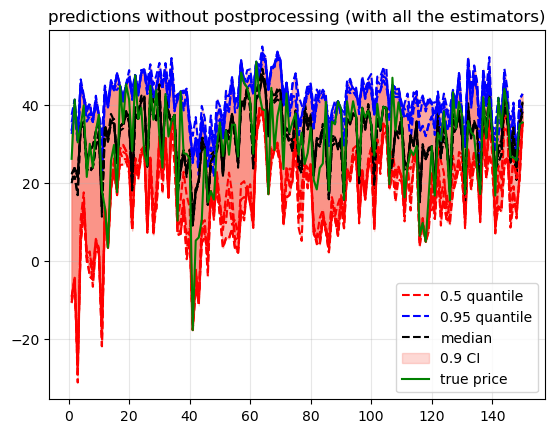

In [46]:
test_june = training_data[training_data['date_wo_h'].isin(target_june_dates)]['target_price']

fig, ax = plt.subplots()
index_june = np.linspace(start=1,stop=150,num=150)
ax.grid(alpha=0.3)
for i in range(4):
    ax.plot(index_june,pred_whole_05[i,:],'r--')
    ax.plot(index_june,pred_whole_95[i,:],'b--')
    ax.plot(index_june,pred_whole_50[i,:],'k--')
    ax.fill_between(index_june,pred_whole_05[i,:],pred_whole_95[i,:],color='salmon',alpha=0.3)

ax.plot(index_june,pred_whole_05[3,:],'r--',label='0.5 quantile')
ax.plot(index_june,pred_whole_95[3,:],'b--',label='0.95 quantile')
ax.plot(index_june,pred_whole_50[3,:],'k--',label='median')
ax.fill_between(index_june,pred_whole_05[3,:],pred_whole_95[i,:],color='salmon',alpha=0.3,label='0.9 CI')

plt.plot(index_june,test_june,'g-',label='true price')
plt.title('predictions without postprocessing (with all the estimators)')
ax.legend()

In [47]:
mean_up = np.mean(pred_whole_95,axis=0)
mean_down = np.mean(pred_whole_05,axis=0)
mean_mid = np.mean(pred_whole_50,axis=0)

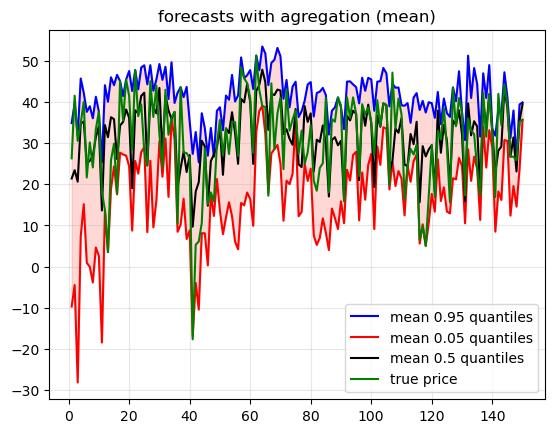

In [48]:
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(index_june,mean_up,'b-',label='mean 0.95 quantiles')
ax.plot(index_june,mean_down,'r-',label='mean 0.05 quantiles')
ax.plot(index_june,mean_mid,'k-',label='mean 0.5 quantiles')
ax.fill_between(index_june,mean_up,mean_down,color='salmon',alpha=0.3)
plt.plot(index_june,test_june,'g-',label='true price')
plt.title('forecasts with agregation (mean)')
ax.legend()


In [49]:
avg_diff = np.mean(mean_up-mean_down)

In [50]:
avg_diff

np.float64(24.335640613386985)

In [51]:
correct = 0
for i in range(150):
    if np.array(test_june)[i]>mean_down[i] and np.array(test_june)[i]<mean_up[i]:
        correct += 1

In [52]:
correct/150

0.8666666666666667

In [53]:
#we do not exactly reach the 90% coverage desired, that is why there is postprocessing
#combining both online agregation and the calibration part

As a conclusion on the results of the quantile regression, we can say that we don't reach the 90% of coverage that was supposed to be reached. However, we can explain this by different reasons. First, I didn't perform a grid search to find the best parameters to get the best results. Moreover, this is supposed to be a sort of 'benchmark value' to see to what extent we could improve this model.

Let's now implement the basics of what OSSCP looks like. As I wasn't familiar with the whole procedures, I implemented the calibration proposed in the beginning of the article, using the quantiles of the residuals of the regression. 

In [54]:
reg_05_june = {}
reg_50_june = {}
reg_95_june = {}
pred_whole_05 = np.zeros((4,0))
pred_whole_95 = np.zeros((4,0))
pred_whole_50 = np.zeros((4,0))
predictions_koop = np.zeros((0,4))
calibration_results = np.zeros((0,5))
for day in tqdm(target_june_dates):
    predictions_05_june = np.zeros((0,5))
    predictions_95_june = np.zeros((0,5))
    predictions_50_june = np.zeros((0,5))
    corresponding_training_windows = make_training_windows_week(day)
    count = 0
    for col in corresponding_training_windows.columns:
        list_train = corresponding_training_windows[col]
        training_set_part = training_data[training_data['date'].isin(list_train)]
        reg_05_june[f'reg_{count}'] = QuantileRegressor(quantile=0.05).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_95_june[f'reg_{count}'] = QuantileRegressor(quantile=0.95).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_50_june[f'reg_{count}'] = QuantileRegressor(quantile=0.5).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        count += 1
    for i in range(count-1):
        to_pred = training_data[training_data['date_wo_h'] == pd.to_datetime(day)].drop(['target_price','date','date_wo_h'],axis=1)
        predictions_05_june = np.vstack((predictions_05_june,reg_05_june[f'reg_{i}'].predict(to_pred)))
        predictions_95_june = np.vstack((predictions_95_june,reg_95_june[f'reg_{i}'].predict(to_pred)))
        predictions_50_june = np.vstack((predictions_50_june,reg_50_june[f'reg_{i}'].predict(to_pred)))
        true_values = np.array(training_data[training_data['date_wo_h'] == pd.to_datetime(day)]['target_price'])
        residuals = np.abs(true_values-reg_50_june[f'reg_{i}'].predict(to_pred)) #we compute the residuals
        calibration_results = np.vstack((calibration_results,residuals))
    flattened_cal = np.ravel(calibration_results)
    value_to_as = np.quantile(a=flattened_cal,q=0.08) #we find the 'deflated' quantile of the residuals, 
    #as it is presented in the article
    predictions_05_june -= value_to_as #we add and substract the desired quantile 
    #in order to obtain an effective coverage of 0.9
    predictions_95_june += value_to_as
    pred_whole_05 = np.hstack((pred_whole_05,predictions_05_june))
    pred_whole_50 = np.hstack((pred_whole_50,predictions_50_june))
    pred_whole_95 = np.hstack((pred_whole_95,predictions_95_june))
    

100%|██████████| 30/30 [01:05<00:00,  2.17s/it]


In [55]:
mean_up = np.mean(pred_whole_95,axis=0)
mean_down = np.mean(pred_whole_05,axis=0)
mean_mid = np.mean(pred_whole_50,axis=0)

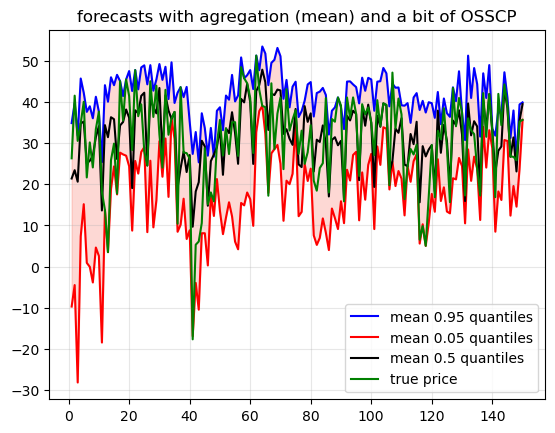

In [56]:
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(index_june,mean_up,'b-',label='mean 0.95 quantiles')
ax.plot(index_june,mean_down,'r-',label='mean 0.05 quantiles')
ax.plot(index_june,mean_mid,'k-',label='mean 0.5 quantiles')
ax.fill_between(index_june,mean_up,mean_down,color='salmon',alpha=0.3)
plt.plot(index_june,test_june,'g-',label='true price')
plt.title("forecasts with agregation (mean) and a bit of OSSCP")
ax.legend()

In [57]:
avg_diff = np.mean(mean_up-mean_down)
print('the average length of the theoretical 0.9 CI is : ',avg_diff)
correct = 0
for i in range(150):
    if np.array(test_june)[i]>mean_down[i] and np.array(test_june)[i]<mean_up[i]:
        correct += 1
print(correct/150)

the average length of the theoretical 0.9 CI is :  24.335640613387003
0.92


We can notice that with almost no difference in terms of the length of the CI, we get a much better coverage.
As I couldn't implement the correct and optimal online aggregation, it seems of course very promising and the width of the CI would probably decrease a lot. 

## Let's try the Koopmans operator approach on the same period

In [58]:
kernel = RBF(length_scale=0.8)
nys_rrr_june = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=10,num_centers=500)

In [59]:
june_and_before = pd.date_range(start='2019-05-21',end='2019-07-01',freq='d')

In [60]:
copy_koop_june = training_data[training_data['date_wo_h'].isin(june_and_before)].copy()
copy_koop_june = copy_koop_june[['date_wo_h','date','price','target_price','nuclear','gas','coal']]
for col in copy_koop_june.drop(['date_wo_h','date'],axis=1).columns:
    copy_koop_june[col] = stats.zscore(copy_koop_june[col])
copy_koop_june['target_last'] = copy_koop_june['target_price'].copy()
copy_koop_june.drop('target_price',axis=1,inplace=True)

In [61]:
whole_pred = np.zeros((0,5))
true_data_whole = np.zeros((0,5))
nys_rrr_june = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=10,num_centers=500)
for day in tqdm(target_june_dates):
    start_train = day - pd.Timedelta(7,"d")
    train_period = pd.date_range(start=start_train,end=day + pd.Timedelta(1,'d'),freq='d')
    temp_train = copy_koop_june[copy_koop_june['date_wo_h'].isin(train_period)].drop(['date','date_wo_h'],axis=1)
    koop_np_temp = np.array(temp_train)
    tr_ctx = traj_to_contexts(koop_np_temp[:-10,:],time_lag=2,context_window_len=3)
    ts_ctx = traj_to_contexts(koop_np_temp[-10:,:],time_lag=2,context_window_len=3)
    nys_rrr_june.fit(tr_ctx)
    pred = nys_rrr_june.predict(ts_ctx)
    pred_to_stack = np.squeeze(pred)
    whole_pred = np.vstack((whole_pred,pred_to_stack))
    true_data = np.squeeze(ts_ctx.lookforward(nys_rrr_june.lookback_len))
    true_data_whole = np.vstack((true_data_whole,true_data))

100%|██████████| 30/30 [15:48<00:00, 31.61s/it]


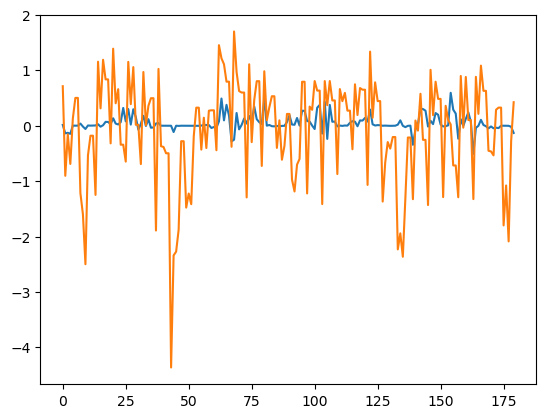

In [62]:
plt.plot(whole_pred[:,-1])
plt.plot(true_data_whole[:,-1])

We can notice that the predictions are quite far from the actual trajectory. This is the last plot obtained after having tried with different variables and different values of the NystroemKernel class. 

### Now, let's try to implement OSSCP-horizon on a month with high volatility

In [65]:
target_sept = pd.date_range(start='2021-09-01',end='2021-09-30',freq='h')
target_sept_dates = pd.date_range(start='2021-09-01',end='2021-09-30',freq='d')

In [66]:
reg_05_sept = {}
reg_50_sept = {}
reg_95_sept = {}
pred_whole_05 = np.zeros((4,0))
pred_whole_95 = np.zeros((4,0))
pred_whole_50 = np.zeros((4,0))
predictions_koop = np.zeros((0,4))
calibration_results = np.zeros((0,5))
for day in tqdm(target_sept_dates):
    predictions_05_sept = np.zeros((0,5))
    predictions_95_sept = np.zeros((0,5))
    predictions_50_sept = np.zeros((0,5))
    corresponding_training_windows = make_training_windows_week(day)
    count = 0
    for col in corresponding_training_windows.columns:
        list_train = corresponding_training_windows[col]
        training_set_part = training_data[training_data['date'].isin(list_train)]
        reg_05_sept[f'reg_{count}'] = QuantileRegressor(quantile=0.05).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_95_sept[f'reg_{count}'] = QuantileRegressor(quantile=0.95).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        reg_50_sept[f'reg_{count}'] = QuantileRegressor(quantile=0.5).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                      y=training_set_part['target_price'])
        count += 1
    for i in range(count-1):
        to_pred = training_data[training_data['date_wo_h'] == pd.to_datetime(day)].drop(['target_price','date','date_wo_h'],axis=1)
        predictions_05_sept = np.vstack((predictions_05_sept,reg_05_sept[f'reg_{i}'].predict(to_pred)))
        predictions_95_sept = np.vstack((predictions_95_sept,reg_95_sept[f'reg_{i}'].predict(to_pred)))
        predictions_50_sept = np.vstack((predictions_50_sept,reg_50_sept[f'reg_{i}'].predict(to_pred)))
        true_values = np.array(training_data[training_data['date_wo_h'] == pd.to_datetime(day)]['target_price'])
        residuals = np.abs(true_values-reg_50_sept[f'reg_{i}'].predict(to_pred)) #we compute the residuals
        calibration_results = np.vstack((calibration_results,residuals))
    flattened_cal = np.ravel(calibration_results)
    value_to_as = np.quantile(a=flattened_cal,q=0.08) #we find the 'deflated' quantile of the residuals, 
    #as it is presented in the article
    predictions_05_sept -= value_to_as #we add and substract the desired quantile 
    #in order to obtain an effective coverage of 0.9
    predictions_95_sept += value_to_as
    pred_whole_05 = np.hstack((pred_whole_05,predictions_05_sept))
    pred_whole_50 = np.hstack((pred_whole_50,predictions_50_sept))
    pred_whole_95 = np.hstack((pred_whole_95,predictions_95_sept))

100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


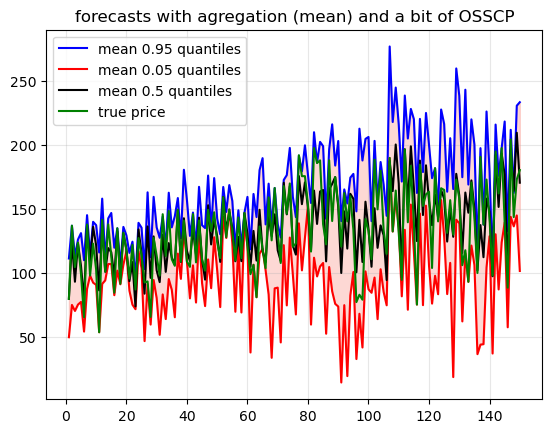

In [67]:
mean_up = np.mean(pred_whole_95,axis=0)
mean_down = np.mean(pred_whole_05,axis=0)
mean_mid = np.mean(pred_whole_50,axis=0)
index_sept = np.linspace(start=1,stop=150,num=150)
test_sept = training_data[training_data['date_wo_h'].isin(target_sept_dates)]['target_price']

fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(index_sept,mean_up,'b-',label='mean 0.95 quantiles')
ax.plot(index_sept,mean_down,'r-',label='mean 0.05 quantiles')
ax.plot(index_sept,mean_mid,'k-',label='mean 0.5 quantiles')
ax.fill_between(index_sept,mean_up,mean_down,color='salmon',alpha=0.3)
plt.plot(index_sept,test_sept,'g-',label='true price')
plt.title("forecasts with agregation (mean) and a bit of OSSCP")
ax.legend()

In [68]:
avg_diff = np.mean(mean_up-mean_down)
print('the average width is : ',avg_diff)
correct = 0
for i in range(150):
    if np.array(test_sept)[i]>mean_down[i] and np.array(test_sept)[i]<mean_up[i]:
        correct += 1
print('the empirical coverage is : ',correct/150)

the average width is :  71.34256545057146
the empirical coverage is :  0.9133333333333333


With a more volatile month, we notice that the width has tripled. However, by the procedure given by the OSSCP-horizon framework, we manage to keep the 0.9 coverage that we wanted. 